In [1]:
import json
from pathlib import Path
import pdb
import csv

import pybo
from pybo import *
import pandas

print(pybo.VERSION)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

0.6.0


## Load lighttag data

In [13]:
paths = [
    Path('raw/lighttag/ner-lists-87_citations-1000_khar_annotations.json'),
    Path('raw/lighttag/ner-lists-87_citations-1000_tsering_annotations.json')
]

In [55]:
# example = [sentence, [(tag, start, end), ...]]

def get_sentence(ann, example_text, tag):
    if tag == 'དབྱེ་བ།' and not '{++~~++}' in example_text: return example_text
    
    sentence = example_text[ann['start']-100: ann['end']+100]
    # right offset
    sentence = sentence[sentence.find(' ')+1:]
    
    #left offset
    left_offset = 0 if sentence.endswith('།') else ("".join(reversed(sentence))).find(' ') + 1   
    sentence = sentence[:len(sentence) - left_offset]
    sentence = sentence.replace('{++~~++}', '')
    return sentence


def is_found(x, value):
    for i in x:
        if i[0] == value: return True
    return False

def get_examples(result):
    example_text = result['example']['content']
    annotations = result['results']['annotations']
    
    examples_cit = []
    examples_list = []
    for ann in annotations:
        if ann['tag'] == 'ལུང་ཚིག་དངོས།' or ann['tag'] == 'དབྱེ་བ།':
            #pdb.set_trace()
            sentence = get_sentence(ann, example_text, ann['tag'])
            start = ann['start']

            #create new start and end indices
            example = [sentence, []]
            for ann in annotations:
                if abs(ann['start'] - start) > 50: continue
                value = ann['value'].replace('{++~~++}', '')
                value = value[:-1] if value[-1] == ' ' else value
                
                n_start = sentence.find(value)
                if n_start == -1: continue
                if ann['tag'] == 'ལུང་ཁུངས།':
                    idx = value.find('ལས།')
                    if idx != -1:
                        value = value[:idx]
                        n_end = n_start + len(value) - 1
                    else:
                        n_end = n_start + len(value) - 1
                elif ann['tag'] == 'ལུང་དེའི་མཛད་པ་པོ།':
                    idx = value.find('པས།')
                    if idx != -1:
                        value = value[:idx]
                        n_end = n_start + len(value) - 1
                    else:
                        n_end = n_start + len(value) - 1
                else:
                    n_end = n_start + len(value) - 1        
                example[1].append((ann['tag'], n_start, n_end, value))
            
            if len(example[1]) > 1:
                if is_found(example[1], 'ལུང་ཚིག་དངོས།'):
                    examples_cit.append(example)
                else:
                    examples_list.append(example)
                
    return examples_cit, examples_list

In [56]:
#test
json_01 = json.load(paths[0].open())

In [57]:
get_examples(json_01['result'][1])

([['འདུས་བྱས་ཐམས་ཅད་ནི་འཇིག་པའི་ཆོས་ཅན་ཡིན་ཏེ། ཆེད་དུ་བརྗོད་པའི་ཚོམ་ལས། ཀྱེ་མ་འདུས་བྱས་རྣམས་མི་རྟག །སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑ཞེས་དང༌། གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་པས། ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ།',
   [('ལུང་ཚིག་དངོས།',
     68,
     126,
     'ཀྱེ་མ་འདུས་བྱས་རྣམས་མི་རྟག །སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑'),
    ('ལུང་ཁུངས།', 43, 63, 'ཆེད་དུ་བརྗོད་པའི་ཚོམ་')]],
  ['།སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑ཞེས་དང༌། གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་པས། ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ། །ནམ་མཁའི་སྤྲིན་བཞིན་འདུས་ཤིང་གྱེས། །བདེན་མེད་སྒྱུ་མའི་ཆོས་རྣམས་ལ། །བདེན་པར་བཟུང་བས་བསླུས་པ་ཡིན། །ཞེས་གསུངས།',
   [('ལུང་དེའི་མཛད་པ་པོ།', 41, 67, 'གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་'),
    ('ལུང་ཚིག་དངོས།',
     72,
     195,
     'ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ། །ནམ་མཁའི་སྤྲིན་བཞིན་འདུས་ཤིང་གྱེས། །བདེན་མེད་སྒྱུ་མའི་ཆོས་རྣམས་ལ། །བདེན་པར་བཟུང་བས་བསླུས་པ་ཡིན། །')]]],
 [])

In [58]:
get_examples(json_01['result'][3])

([],
 [['བྱང་ཕྱོགས་ན་ནི་ཉེས་དམིགས་ལྔ་ཡོད་དེ། མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །',
   [('དབྱེ་གཞི།', 15, 24, 'ཉེས་དམིགས་'),
    ('དབྱེ་བ།',
     36,
     174,
     'མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །')]]])

In [59]:
def get_dataset(paths):
    dataset = [[], []]
    for path in paths:
        data = json.load(path.open())
        for ex in data['result']:
            examples_cit, examples_list = get_examples(ex)
            if examples_cit: dataset[0].extend(examples_cit)
            if examples_list: dataset[1].extend(examples_list)
            examples_cit, examples_list = [], []
    return dataset

In [60]:
ds = get_dataset(paths)

In [61]:
len(ds)

2

In [63]:
is_found([o[1] for o in ds[1]], 'ལུང་ཚིག་དངོས།')

False

### Check for sentence length

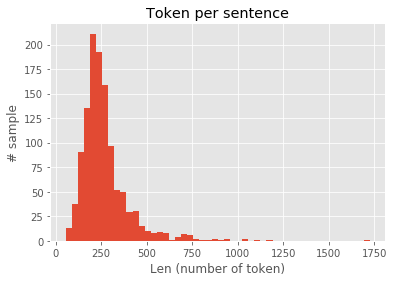

In [93]:
plt.hist([len(s[0]) for s in ds], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sample')
plt.show()

In [94]:
max([len(s[0]) for s in ds])

1727

In [103]:
for i, d in enumerate(ds):
    if len(d[0]) > 1000:
        print(i, d[0])

445 །དུས་བརྒྱ་ཟ་མ་གཅིག་ཡིན་དིང་རི་བ། །ཞེས་གསུངས། མདོར་ན་ཀུན་མཁྱེན་ཆོས་རྗེས། ཁོམ་ལྡན་མི་ཡི་འགྲོ་བ་རྙེད་གྱུར་ཅིང༌། །ཡང་དག་དགེ་བའི་བཤེས་དང་མཇལ་དུས་འདིར། །བདེ་འགྲོ་ཐར་པའི་སྐས་ལ་མ་འཛེགས་ན། །ཕྱིས་ནས་དལ་འབྱོར་ལུས་རྙེད་ཤིན་ཏུ་དཀའ། །དལ་དང་འབྱོར་བའི་མི་ལུས་མ་ཐོབ་ན། །སྡིག་པ་འབའ་ཞིག་མངོན་པར་འཕེལ་བ་ལས། །དགེ་གོམས་ཆོས་ལ་སྤྱོད་པའི་སྐབས་མི་རྙེད། །དམ་པའི་ཆོས་ཞེས་སྒྲ་ཡང་ཐོས་མི་འགྱུར། །དམ་པའི་ཆོས་དང་འཕྲད་པར་མ་གྱུར་ན། །སྡིག་པའི་དབང་གིས་འོག་ནས་འོག་ཏུ་འགྲོ། །ངན་སོང་གནས་ནས་ཐོན་པར་མ་གྱུར་ན། །སྔ་མའི་སྡུག་བསྔལ་དྲག་པོས་མནར་བཞིན་དུ། །ཕྱི་མའི་ལས་ངན་དཔག་མེད་སོག་པས་ན། །མུ་མཐའ་མེད་པའི་འཁོར་བར་རྟག་ཏུ་འཁྱམས། །མཐའ་མེད་སྡིག་པའི་རྒྱ་མཚོར་འཁྱམས་དུས་འདིར། །རང་རང་ལས་ཀྱི་རྦ་ཀློང་དྲག་པོས་འཁྲུགས། །སྡུག་བསྔལ་གཏིང་མཐའ་དཔག་ཏུ་མེད་པ་ལས། །ལས་ཟད་བར་དུ་ཡང་ཡང་བརྣག་དགོས་སོ། །རང་གི་ལས་ངན་འཁྲུལ་པའི་མེ་ཚོགས་ལ། །རྒྱལ་བའི་ཐུགས་རྗེས་དངོས་སུ་གཞིལ་དཀའ་སྟེ། །སྔོན་འདས་སངས་རྒྱས་གྲངས་མེད་བྱོན་ན་ཡང༌། །བདག་ཅག་ད་དུང་སྲིད་པར་འཁྱམས་ལ་ལྟོས། །དེ་བས་ད་ལྟ་དལ་འབྱོར་ཐོབ་དུས་འདིར། །འཁོར་བའི་སྡུག་བསྔལ་དཔག་མེད་བསམས་བྱས་ནས། །ཞི་བ་རབ་བཟང་ཐར་པའི་སྐྱེད་ཚལ་དུ། །དེ་རིང

In [97]:
test = '།ཤིན་ཏུ་འཕྲེང་{འཁྲེང}བའི་ནོར་དང་འཁོར་ལ་སོགས། །ཕངས་པ་མེད་པར་ཡོངས་སུ་གཏང་བར་བྱ། །རྒྱལ་བུ་སྙིང་སྟོབས་ཆེན་པོར་གྱུར་པ་ན། །སྟག་མོ་རང་གི་ཤ་ཡིས་གསོས་པ་ལྟར།'

for i, result in enumerate(json_01['result']):
    if test in result['example']['content']:
        print(i)

245


### Tonkenize the sentence and apply tag

In [68]:
wt = pybo.tokenizers.wordtokenizer.WordTokenizer()

Loading Trie... (2s.)


In [69]:
def tokenize(sentence):
    result = []
    tokens = wt.tokenize(sentence)
    for token in tokens:
        result.append((token.text, token.pos, token.lemma))
    return result
    
def apply_tag(tags, tokens):
    tags = sorted(tags, key=lambda x: x[1])
    token_last_char_idx = -1
    tag_idx = 0
    is_begining = True
    
    result = []
    for token in tokens:
        token_last_char_idx += len(token[0])
        tag = tags[tag_idx]
        if token_last_char_idx > tag[1] and token_last_char_idx <= tag[2]:
            if is_begining:
                result.append(f'B-{tag[0]}')
                is_begining = False
            else:
                result.append(f'I-{tag[0]}')
        else:
            result.append('O')
            if len(result) > 2 and result[-2][0] in ['B', 'I']: 
                tag_idx = 1
                is_begining = True
    
    return result

def get_tokens_with_ner_tag(example):
    sentence = example[0]
    tags = example[1]
    
    tokens = tokenize(sentence)
    tokens_tag = apply_tag(tags, tokens)
    
    return tokens, tokens_tag

In [70]:
get_tokens_with_ner_tag(ds[0][4])

([('།', '', ''),
  ('སྐྱེ་', 'NOUN', 'སྐྱེ་'),
  ('ཞིང་', 'PART', 'ཞིང་'),
  ('འཇིག་པ', 'VERB', 'འཇིག་པ་'),
  ('འི་', 'PART', 'གི་'),
  ('ཆོས་ཅན་', 'NOUN', 'ཆོས་ཅན་'),
  ('ཡིན', 'PART', 'ཡིན་'),
  ('༑ ༑', '', ''),
  ('ཞེ', 'PART', 'ཞེ་'),
  ('ས་', 'PART', 'གིས་'),
  ('དང༌', 'PART', 'དང་'),
  ('། ', '', ''),
  ('གྲུབ་ཆེན་', 'NOUN', 'གྲུབ་ཆེན་'),
  ('ཁྱུང་པོ་', 'OTHER', 'ཁྱུང་པོ་'),
  ('རྣལ་འབྱོར་', 'NOUN', 'རྣལ་འབྱོར་'),
  ('པ', 'PART', 'པ་'),
  ('ས', 'PART', 'གིས་'),
  ('། ', '', ''),
  ('ཀྱེ་མ་', 'INTJ', 'ཀྱེ་མ་'),
  ('འདུས་བྱས་', 'NOUN', 'འདུས་བྱས་'),
  ('མི་རྟག་', 'OTHER', 'མི་རྟག་'),
  ('སྟེ', 'PART', 'སྟེ་'),
  ('། །', '', ''),
  ('ནམ་མཁ', 'NOUN', 'ནམ་མཁའ་'),
  ('འི་', 'PART', 'གི་'),
  ('སྤྲིན་', 'NOUN', 'སྤྲིན་'),
  ('བཞིན་', 'OTHER', 'བཞིན་'),
  ('འདུ', 'OTHER', 'འདུ་'),
  ('ས་', 'PART', 'གིས་'),
  ('ཤིང་', 'PART', 'ཤིང་'),
  ('གྱེས', 'OOV', 'གྱེས་'),
  ('། །', '', ''),
  ('བདེན་', 'NOUN', 'བདེན་'),
  ('མེད་', 'ADJ', 'མེད་'),
  ('སྒྱུ་མ', 'NOUN', 'སྒྱུ་མ་'),
  ('འི་', 'PART', '

In [71]:
get_tokens_with_ner_tag(ds[1][0])

([('བྱང་ཕྱོགས་', 'NOUN', 'བྱང་ཕྱོགས་'),
  ('ན་', 'PART', 'ན་'),
  ('ནི་', 'PART', 'ནི་'),
  ('ཉེས་དམིགས་', 'NOUN', 'ཉེས་དམིགས་'),
  ('ལྔ་', 'OTHER', 'ལྔ་'),
  ('ཡོད་', 'ADJ', 'ཡོད་'),
  ('དེ', 'PART', 'དེ་'),
  ('། ', '', ''),
  ('མཐོན་', '', 'མཐོན་'),
  ('དམན་', 'NOUN', 'དམན་'),
  ('ཅན་', 'ADJ', 'ཅན་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('སྡོང་དུམ་', 'PROPN', 'སྡོང་དུམ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('ཚེར་མ', 'NOUN', 'ཚེར་མ་'),
  ('ས་', 'PART', 'གིས་'),
  ('གང་བ་', 'VERB', 'གང་བ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('རྡོ་བ་', 'NOUN', 'རྡོ་བ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('གསེག་མ་', 'NOUN', 'གསེག་མ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('གྱོ་མོ་', 'NOUN', 'གྱོ་མོ་'),
  ('མང་བ་', 'VERB', 'མང་བ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('ཁྱི་', 'OTHER', 'ཁྱི་'),
  ('ཟ་བ་', 'VERB', 'ཟ་བ་'),
  ('དང་', 'PART', 'དང་'),
  ('། ', '', ''),
  ('བུད་མེད་', 'NOUN', 'བུད་མེད་'),
  ('གནས་', 'NOUN', 'གནས་'),
  ('ངན་',

In [72]:
xs = [len(tokenize(s[0])) for s in ds[0]]

In [73]:
max(xs)

440

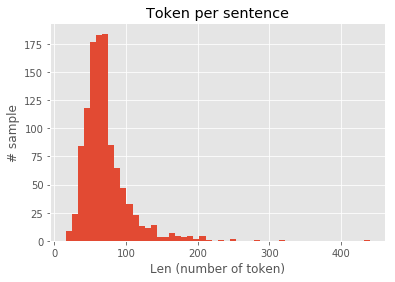

In [74]:
plt.hist(xs, bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sample')
plt.show()

In [75]:
xs = [len(tokenize(s[0])) for s in ds[1]]

In [76]:
max(xs)

143

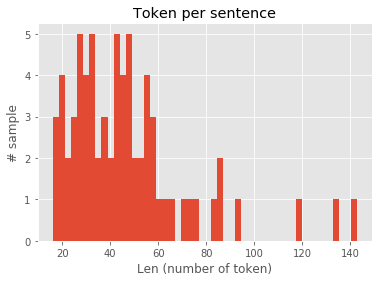

In [77]:
plt.hist(xs, bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sample')
plt.show()

### Save data to CSV file

In [78]:
output_dir = Path('./raw')
output_dir.mkdir(exist_ok=True)
output_file_cit = output_dir/'ner-lists-87_citations-1000_citation.csv'
output_file_list = output_dir/'ner-lists-87_citations-1000_list.csv'

In [79]:
def save_to_csv(file, ds):
    with file.open('w') as csv_file:
        fieldnames = ['sentence_idx', 'word', 'tag', 'pos', 'lemma']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        
        for i, d in enumerate(ds):
            for token, tag in zip(*get_tokens_with_ner_tag(d)):
                writer.writerow({
                    'sentence_idx': i+1, 
                    'word': token[0],
                    'tag': tag,
                    'pos': token[1],
                    'lemma': token[2]
                })

In [80]:
save_to_csv(output_file_cit, ds[0])

In [81]:
save_to_csv(output_file_list, ds[1])

### Read data with pandas

In [82]:
df = pandas.read_csv(output_file_cit)

In [83]:
df.head(74)

,sentence_idx,word,tag,pos,lemma
0,1,རྣམ་པ་,O,NOUN,རྣམ་པ་
1,1,ལྔ,O,OTHER,ལྔ་
2,1,འི་,O,PART,གི་
3,1,བ,O,PART,བ་
4,1,ར་,O,PART,ལ་
5,1,བཅོམ་པ,O,VERB,བཅོམ་པ་
6,1,། །,O,NaN,NaN
7,1,གཉིས་,O,OTHER,གཉིས་
8,1,པ་,O,PART,པ་
9,1,ལ་,O,PART,ལ་


In [84]:
df = pandas.read_csv(output_file_list)
df.head(74)

,sentence_idx,word,tag,pos,lemma
0,1,བྱང་ཕྱོགས་,O,NOUN,བྱང་ཕྱོགས་
1,1,ན་,O,PART,ན་
2,1,ནི་,O,PART,ནི་
3,1,ཉེས་དམིགས་,B-དབྱེ་གཞི།,NOUN,ཉེས་དམིགས་
4,1,ལྔ་,O,OTHER,ལྔ་
5,1,ཡོད་,O,ADJ,ཡོད་
6,1,དེ,O,PART,དེ་
7,1,།,O,NaN,NaN
8,1,མཐོན་,B-དབྱེ་བ།,NaN,མཐོན་
9,1,དམན་,I-དབྱེ་བ།,NOUN,དམན་
